# Calibrating the MOHYSE hydrological model using OSTRICH on the Raven server

Here we use birdy's WPS client to calibrate the MOHYSE hydrological model on the server and analyze the calibrated parameter set and hydrograph. 

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

url = "http://localhost:9099/wps"
wps = WPSClient(url)

In [2]:
# The model parameter boundaries. Can either be a string of comma separated values, a list, an array or a named tuple. 
low_p = '0.01, 0.01, 0.01, -5.00, 0.01, 0.01, 0.01, 0.01'
high_p = '20.0, 1.0, 20.0, 5.0, 0.5, 1.0, 1.0, 1.0'
low_h = '0.01, 0.01'
high_h = '15.0, 15.0'
          
# Forcing files
ts=TESTDATA['ostrich-mohyse-nc-ts']

# OSTRICH configuration parameters
config = dict(
    algorithm='DDS',
    max_iterations=10,
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    lowerbounds=low_p,
    upperbounds=high_p,
    start_date=dt.datetime(1954, 1, 1),
    duration=208,
    hruslowerbounds=low_h,
    hrusupperbounds=high_h,
    )

# Let's call Ostrich with the timeseries, calibration parameters and other configuration parameters
resp = wps.ostrich_mohyse(ts=str(ts), **config)

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[calibration, hydrograph, storage, solution, diagnostics, calibparams] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 
# Here there is a problem because we only get the 8 calibrated parameters but not the 2 "hru" calibrated parameters, which means we can't run the code afterwards with the calibrated HRU parameters.

In [3]:
print(calibparams)

2.265868, 0.5946992, 3.08262, -1.713234, 0.399964, 0.817625, 0.1728091, 0.2371443


The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [16]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 209, nbasins: 1)>
array([[0.      ],
       [0.      ],
       [0.      ],
       ...,
       [0.007406],
       [0.006391],
       [0.005514]])
Coordinates:
  * time        (time) datetime64[ns] 1954-01-01 1954-01-02 ... 1954-07-28
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

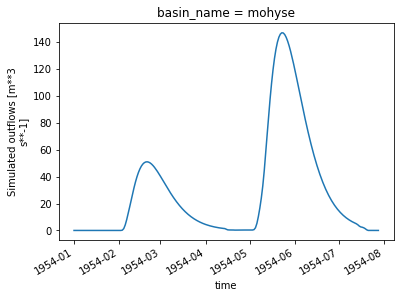

In [17]:
hydrograph.q_sim.plot()

In [18]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby('time.month').mean())

Max:  <xarray.DataArray 'q_sim' ()>
array(146.85637)
Mean:  <xarray.DataArray 'q_sim' ()>
array(28.636496)
Monthly means:  <xarray.DataArray 'q_sim' (month: 7)>
array([ 0.      , 32.668187, 18.570773,  1.424412, 84.384503, 56.746038,
        4.771117])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7


/home/ets/miniconda3/lib/python3.7/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


## Now, let's do a test: Let's run the model again using the same parameters and check to see that the NSE is the same. 

First, lets extract the diagnostics from the optimized run, giving the calibration NSE.

In [19]:
diagnostics

'observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,\nHYDROGRAPH,./model//Salmon-River-Near-Prince-George_meteo_daily.nc,0.651872,30.5704,\n'

## Run the MOHYSE WPS:

In [20]:
# Model configuration parameters
config = dict(area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    start_date=dt.datetime(1954, 1, 1),
    duration=208,
             )
# Let's call the model with the timeseries, model parameters and other configuration parameters
resp = wps.raven_mohyse(ts=str(ts), params=calibparams, **config)
[hydrograph, storage, solution, diagnostics2] = resp.get(asobj=True)

Now lets check to see if the diagnostics are the same.

In [21]:
diagnostics2

'observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,\nHYDROGRAPH,/tmp/pywps_process_o3sh820c/Salmon-River-Near-Prince-George_meteo_daily.nc,-1.06254,74.4102,\n'